# Dealing with multiple feeds


In some cases the fed-batch process uses multiple feeding mediums. This is typically the case in cultivation of mammalians cells. This tutorial will show how to use the pseudo batch transformation to handle multiple feeding mediums. We will, again, use simulated data to showcase the workflow. This fed-batch process seeks to mimic a cultivation of mammalians cells. These simulated cells require two substrates to grow; glucose and glutamine. The bioreactor is fed with two different feed mediums, one containing concentrated glucose and one complex medium that contain glucose, and glutamine. Furthermore, the feeding is not done through a "continuous" exponential feed, but instead as pulse feed, i.e. at certain time points a given volume of each feed is added to the bioreactor.

In the simulation 12 samples are drawn over the course of the fermentation and 0.1 hours after each sample feed is added.

First we will setup the environment and load the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pseudobatch import pseudobatch_transform_pandas
from pseudobatch.datasets import load_cho_cell_like_fedbatch
from pseudobatch.datasets._dataloaders import _prepare_simulated_dataset

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
fedbatch_df_measurement = load_cho_cell_like_fedbatch(sampling_points_only=True)

## Inspect the dataset

First, let's quickly inspect the dataframe

In [3]:
(fedbatch_df_measurement
    .filter(['timestamp', 'sample_volume', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum1', 'v_Feed_accum2'])
    .head()
)

,timestamp,sample_volume,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum1,v_Feed_accum2
0,10.0,170.0,1.644817,47.882089,0.940479,1000.0,0.0,0.0
1,16.0,170.0,3.007637,50.337209,2.106177,935.0,100.0,5.0
2,22.0,170.0,5.466735,50.535418,4.170358,870.0,200.0,10.0
3,28.0,170.0,9.758328,47.107608,7.737765,805.0,300.0,15.0
4,34.0,170.0,16.782229,38.381155,13.547532,740.0,400.0,20.0


This dataframe is structured very similar to the one used in the previous tutorial. This time the fed-batch process utilized two feed streams and therefore there are two accumulated feed columns. It is important to not the even though the feed is added in pulses the pseudo batch still takes accumulated amounts.

In this simulation feed 1 contained only glucose, while feed 2 contain both glucose and Glutamine. We will store the concentrations in some variables here.

In [4]:
glucose_in_feed1 = fedbatch_df_measurement.c_Glucose_feed1.iloc[0] 
glucose_in_feed2 = 0  
Glutamine_in_feed1 = fedbatch_df_measurement.c_Glutamine_feed1.iloc[0]
Glutamine_in_feed2 = fedbatch_df_measurement.c_Glutamine_feed2.iloc[0]

## Applying the pseudo batch transformation
We can now apply the pseudo batch transformation to the data. Notice that to include both feeds we simply supply a list of the columns names in the `accumulated_feed_colnames` argument. The `concentrations_in_feed` is specified as follows: The outer list iterates over the measured concentrations (in this case Biomass, Glucose, Product, CO2, Glutamine), while the inner list iterates over the feeding mediums. **Important:** the order HAS to be the same for `concetration_in_feed` and both `measured_concentration_colnames` and `accumulated_feed_colname`!

In [5]:
fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo", "c_Glutamine_pseudo"]] = pseudobatch_transform_pandas(
    df=fedbatch_df_measurement,
    measured_concentration_colnames=['c_Biomass', 'c_Glucose', 'c_Product', 'c_CO2', 'c_Glutamine'],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname=['v_Feed_accum1', 'v_Feed_accum2'],
    concentration_in_feed=[[0, 0], [glucose_in_feed1, glucose_in_feed2], [0, 0], [0, 0], [Glutamine_in_feed1, Glutamine_in_feed2]],
    sample_volume_colname='sample_volume'
)

We can take a quick look at what the pseudo batch transformed data looks like by plotting it against time.

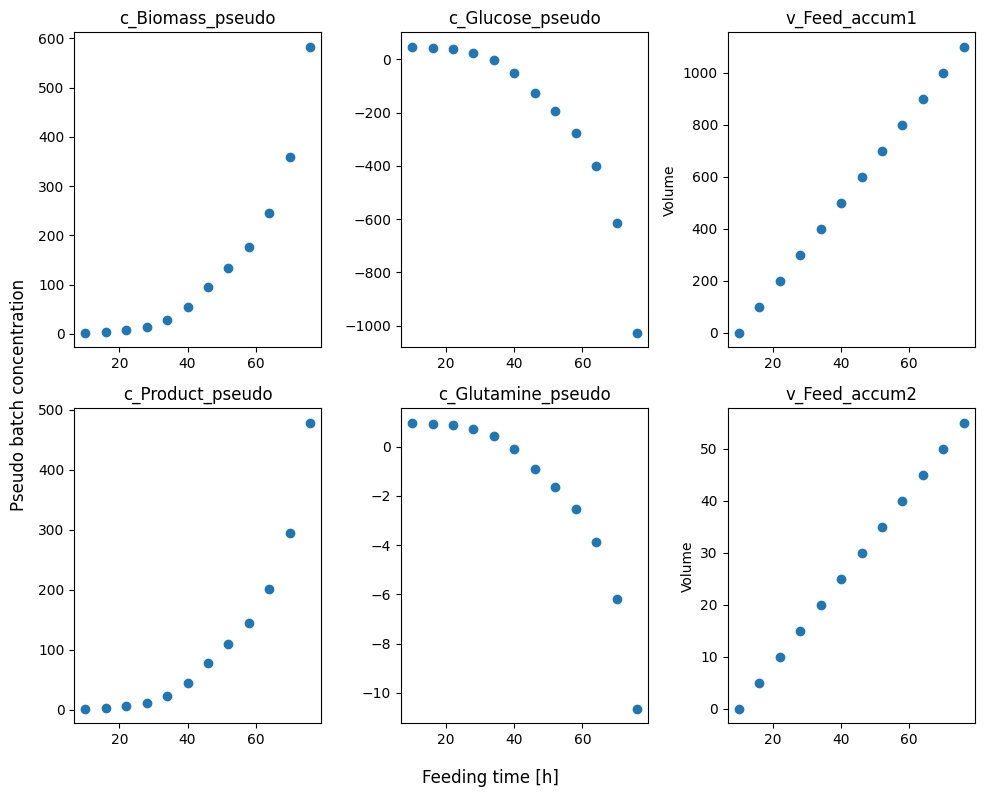

In [6]:
plot_cols = ['c_Biomass_pseudo', 'c_Glucose_pseudo','v_Feed_accum1','c_Product_pseudo',  'c_Glutamine_pseudo', 'v_Feed_accum2']
fig, axes = plt.subplots(nrows=2, ncols=len(plot_cols)//2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), plot_cols):
    ax.scatter(fedbatch_df_measurement.timestamp, fedbatch_df_measurement[col])
    ax.set_title(col)

    if col.startswith('v_'):
        ax.set_ylabel('Volume')

fig.supxlabel('Feeding time [h]')
fig.supylabel('Pseudo batch concentration')
fig.tight_layout()

## Estimate substrate yields
We can now estimate the yield coefficient for the two substrates.

In [7]:
Yxglucose, _ = np.polyfit(fedbatch_df_measurement.c_Biomass_pseudo.to_numpy(), fedbatch_df_measurement.c_Glucose_pseudo.to_numpy(), 1)
Yxglutamine, _ = np.polyfit(fedbatch_df_measurement.c_Biomass_pseudo.to_numpy(), fedbatch_df_measurement.c_Glutamine_pseudo.to_numpy(), 1)

print("Estimated Yxglucose: ", np.abs(Yxglucose))
print("True Yxglucose: ", fedbatch_df_measurement.Yxs.iloc[0])
print("Estimated Yxglutamine: ", np.abs(Yxglutamine))
print("True Yxglutamine: ", fedbatch_df_measurement.Yxs2.iloc[0])

Estimated Yxglucose:  1.8500000000000019
True Yxglucose:  1.85
Estimated Yxglutamine:  0.02000000000000001
True Yxglutamine:  0.02


As you see the yields are correctly estimated also when multiple feed mediums are used. Please refer to the other tutorials for guides on estimation of rates or other parameters.